# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'



"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

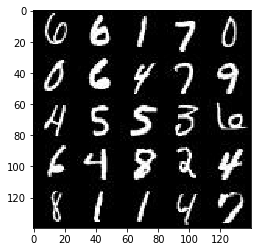

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

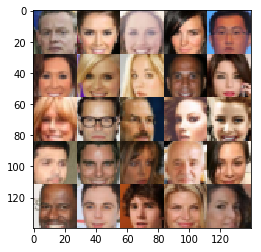

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,shape = (None, image_width,image_height,image_channels), name = "input_real")
    input_z = tf.placeholder(tf.float32,shape = (None, z_dim), name = "input_z")
    learning_rate = tf.placeholder(tf.float32,shape=[], name = "learning_rate")
    
    # I am not sure why I had to place shape=[] in learn_rate, for some reason if I ommit it TensorFlow has an error.
    # ERROR:tensorflow:==================================Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>If you want to mark it as used call its "mark_used()" method.It was originally created here:

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Parameter Initializations
        drop_rate = 0.3# For drop_out 50%
        # If I understood correctly, batch normalization should take care of the dropout as well. I will play around some more if needed.
        # For now, dropout layer is not yet activated in between the layers
        # I did use it on the dense layer of logits just to avoid some overtraining.
        alpha_val = 0.2

        # First layer
        L1 = tf.layers.conv2d(inputs= images,filters = 64,kernel_size = 5,strides = 2,padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        L1 = tf.maximum(alpha_val*L1, L1)# Leaky ReLU
        L1 = tf.layers.dropout(inputs = L1,rate  = drop_rate)
        # No batchnormalization as prescribed in the paper: UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS
        # Second Layer
        
        L2 = tf.layers.conv2d(inputs= L1,filters = 128,kernel_size = 5,strides = 2,padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        L2 = tf.layers.batch_normalization(inputs = L2,training = True)
        L2 = tf.maximum(alpha_val*L2, L2)
        L2 = tf.layers.dropout(inputs = L2,rate  = drop_rate)
        
        # Third Layer

        L3 = tf.layers.conv2d(inputs= L2,filters = 256,kernel_size = 5,strides = 1,padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        L3 = tf.layers.batch_normalization(inputs = L3,training = True)
        L3 = tf.maximum(alpha_val*L3, L3)
        L3 = tf.layers.dropout(inputs = L3,rate  = drop_rate)

        # Reshape/Flatten
        flatten_ = tf.reshape(tensor = L3,shape = (-1,4*4*256)) # Is there a difference if I used tf.layers.flatten()??
        
        # Activate
        logits = tf.layers.dense(inputs = flatten_,units = 1) 
        
        logits = tf.layers.dropout(inputs = logits,rate  = drop_rate)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Initializations
    # Initializations
    alpha_val = 0.2 # Imbalance between Gen and Disc
    drop_rate = 0.3

    
    with tf.variable_scope('generator', reuse=not is_train): # Enabling variable_scope reuse.
                
        # Fist Layer
        L1 = tf.layers.dense(z,(7*7*512))
        L1 = tf.reshape(tensor = L1,shape = (-1,7,7,512),name = 'L1')
        L1 = tf.layers.batch_normalization(inputs = L1,training = is_train)
        L1 = tf.maximum(alpha_val*L1, L1) # 7x7
        L1 = tf.layers.dropout(inputs = L1,rate  = drop_rate)
                   
        # Second Layer
        L2 = tf.layers.conv2d_transpose(inputs = L1,filters = 256,kernel_size = 5,strides = 2,padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        L2 = tf.layers.batch_normalization(inputs = L2,training = is_train)
        L2 = tf.maximum(alpha_val*L2, L2) # 14x14
        L2 = tf.layers.dropout(inputs = L2,rate  = drop_rate)
        
        # Third
        L3 = tf.layers.conv2d_transpose(inputs = L2,filters = 128,kernel_size = 5,strides = 2,padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        L3 = tf.layers.batch_normalization(inputs = L3,training = is_train)
        L3 = tf.maximum(alpha_val*L3, L3) # 28x28 so next stride should be 1 to pass the test
        L3 = tf.layers.dropout(inputs = L3,rate  = drop_rate)
        
        # Logits and tanh output
        logits = tf.layers.conv2d_transpose(inputs = L3,filters = out_channel_dim,kernel_size = 5,strides = 1,padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits) # tanh activation as prescribed in one of the papers
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
     # TODO: Implement Function
    smooth = 0.1 # for smoothing function
    # Just reusing the model loss from DCGAN exercise
    g_model = generator(input_z,out_channel_dim) # Generate some images for the fake discrimination
    d_model_real , d_logits_real = discriminator(input_real) # Discriminate from Actual inputs
    d_model_fake , d_logits_fake = discriminator(g_model,reuse=True) # Discriminate from Generated inputs
    
    # Added Smoothing on real
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)*(1-smooth))) # For the real inputs
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake))) # For the generator inputs
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake))) # For the generator itself, its the same as the fake because that was what the output of the generator was used on (?).
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Nothing Fancy, Reused from the DCGAN SVHN notebook.
    # First we need to group our variables based on their scope (i.e. discriminator and generator)
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    width, height, channel = data_shape[1],data_shape[2],data_shape[3]
    input_real, input_z, learn_rate = model_inputs(width,height,channel,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss,g_loss,learn_rate,beta1)
    
    saver = tf.train.Saver()
    steps = 0
    
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images =batch_images*2.0 # Based on the first reviewer's input. Used to rescale the images.
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Call optimizers
                
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z: batch_z,learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_z: batch_z,input_real: batch_images,learn_rate: learning_rate})
                
                #Every 20 steps: Just to check if it is converging
                if steps % 20 == 0: 
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d,train_loss_g))
                #Printout every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 16,input_z,channel,data_image_mode)
                    #show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
            
        saver.save(sess,'./generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.8969
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 2.9609
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 0.9619


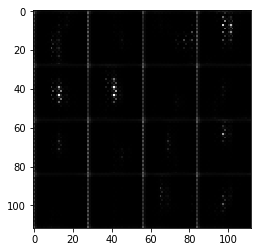

Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.4809
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.5216
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.4557
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.6204


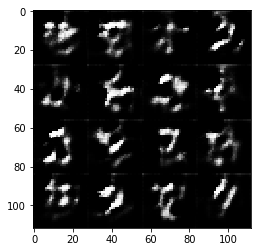

Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.4906
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.5049
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.6653


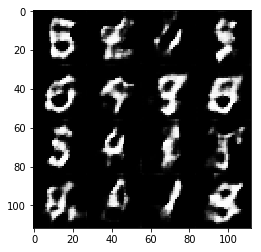

Epoch 1/2... Discriminator Loss: 1.5235... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.5890


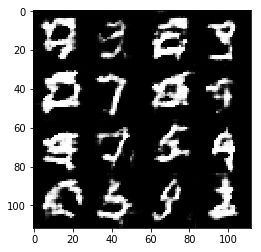

Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.4310... Generator Loss: 1.0673
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 1.0179


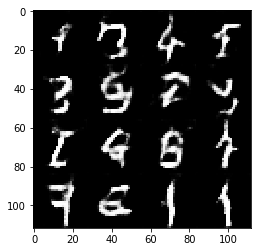

Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.9997
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 1.0601
Epoch 1/2... Discriminator Loss: 1.5977... Generator Loss: 1.3533
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 1.1133
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 1.1380


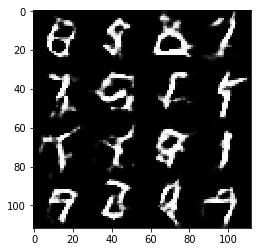

Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.6369


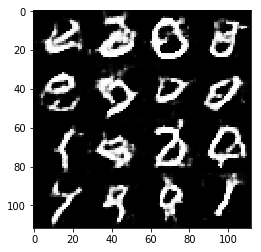

Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 0.4056
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.6551
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.7246


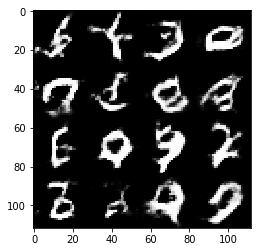

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.5367
Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 1.0749


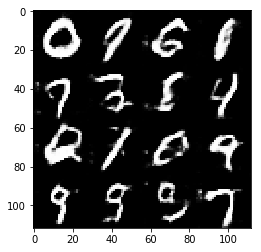

Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.5298
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.5932


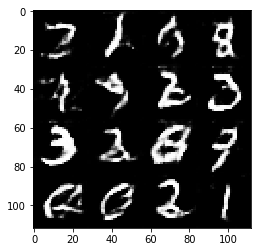

Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.9649


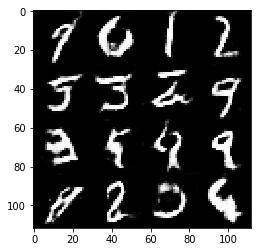

Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 0.7917
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 1.0052
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 1.1734
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.6823


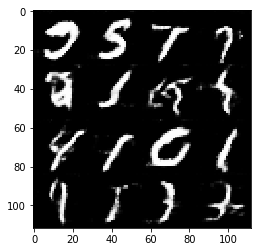

Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.2355... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 1.0102
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.1465


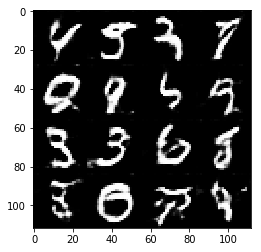

Epoch 1/2... Discriminator Loss: 1.2963... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.7125
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 1.1212


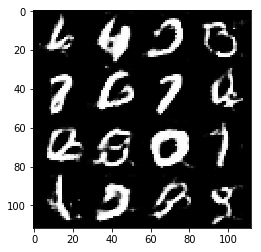

Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 1.2107
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 1.1859
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.7849


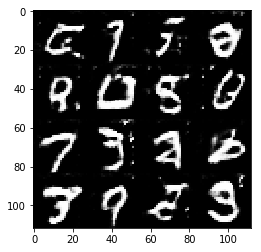

Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.4871... Generator Loss: 1.1496
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 1.5879
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.9642


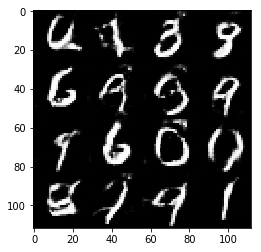

Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7743
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 1.3784
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 1.0653


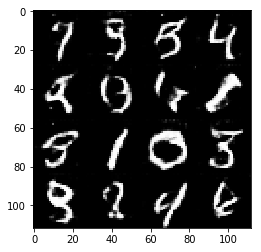

Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.9169
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 0.9579


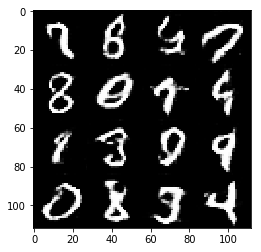

Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.5751
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.3460... Generator Loss: 1.6773
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.7488


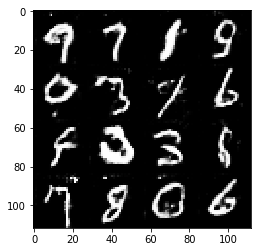

Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.6672
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.4285... Generator Loss: 0.5211


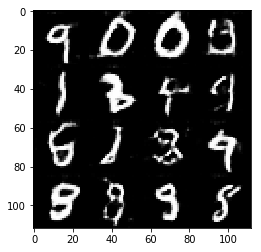

Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.6208
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 1.3153... Generator Loss: 0.5940
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.7783


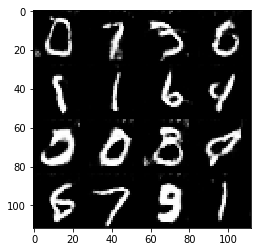

Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 1.1966... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.3204... Generator Loss: 0.6188


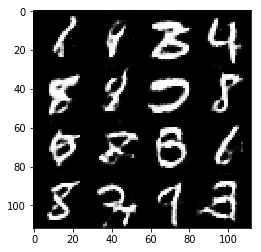

Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.3424... Generator Loss: 0.5680
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.5262... Generator Loss: 0.4721
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.7567


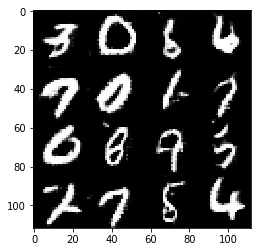

Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 1.2352... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.8149
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 1.1385
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.1953


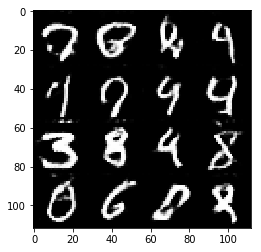

Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 0.9575
Epoch 2/2... Discriminator Loss: 1.1972... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.4582
Epoch 2/2... Discriminator Loss: 1.2582... Generator Loss: 1.2760


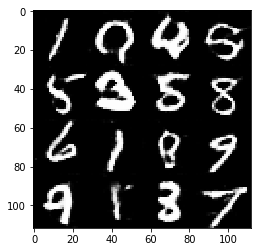

Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.6198
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.5543


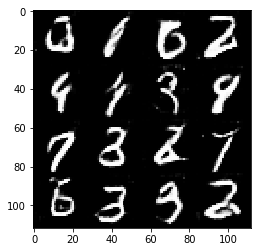

Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 1.2601
Epoch 2/2... Discriminator Loss: 1.3902... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.9889
Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 1.0671
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.5524


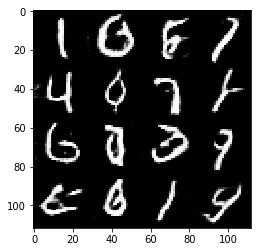

Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 1.0692
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 1.1806
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 1.5406... Generator Loss: 0.4375


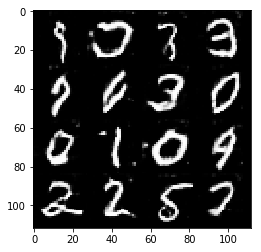

Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 1.5244
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 1.3418
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.7228


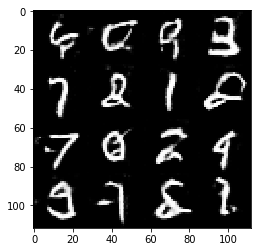

Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 1.9285
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.5464


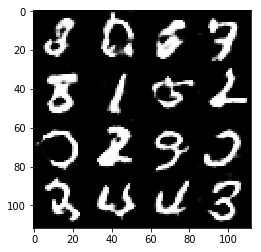

Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 1.2646
Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.5761
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.6722


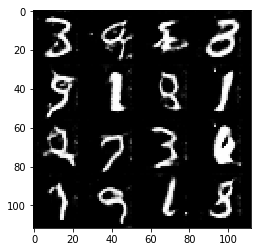

Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 1.1540
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 1.1680
Epoch 2/2... Discriminator Loss: 1.5539... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.4837
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.7648


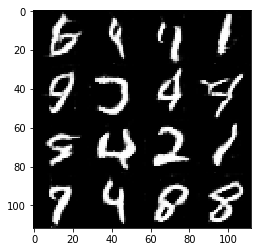

Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 1.5637
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 1.0876
Epoch 2/2... Discriminator Loss: 1.5984... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 1.1507
Epoch 2/2... Discriminator Loss: 1.8665... Generator Loss: 0.2721


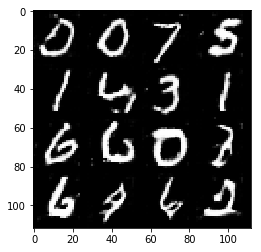

Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 1.5714
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 0.8725


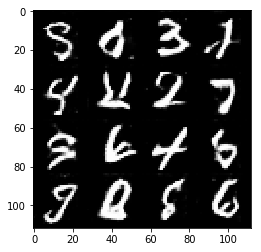

Epoch 2/2... Discriminator Loss: 1.5253... Generator Loss: 1.5874
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.1256
Epoch 2/2... Discriminator Loss: 1.3129... Generator Loss: 1.8176
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 1.0485


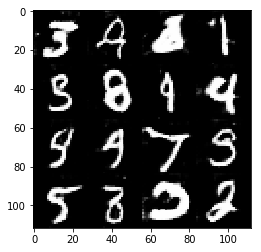

Epoch 2/2... Discriminator Loss: 1.1606... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.3269
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.7715


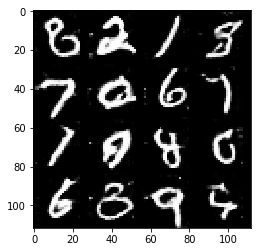

Epoch 2/2... Discriminator Loss: 0.9677... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.8071
Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 2.1570
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 0.9574


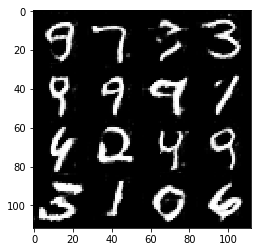

Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 1.6416
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.9104


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.8361
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 2.2626
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 2.6012
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.8783


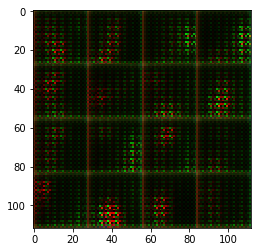

Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 0.5719... Generator Loss: 2.5298


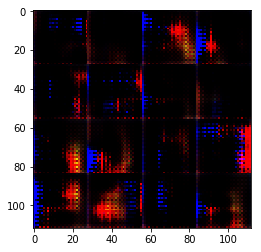

Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 3.0922
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.5243


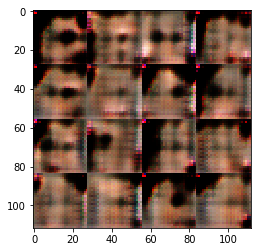

Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6526


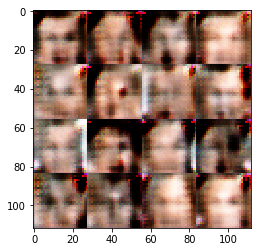

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.5753
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8470


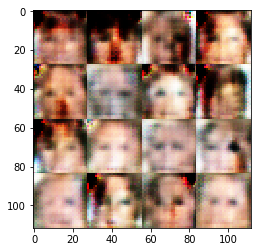

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.6741


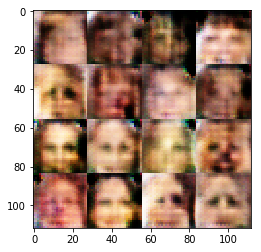

Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 1.0584


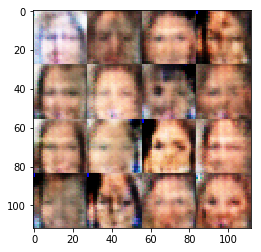

Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6477


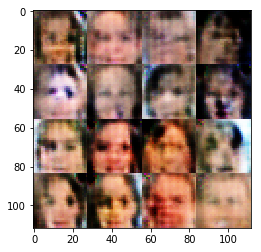

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.9811
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7224


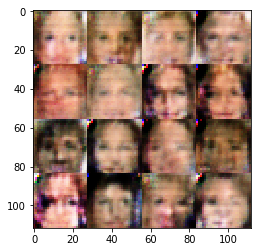

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.0226


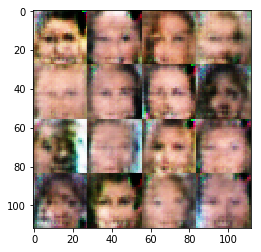

Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 1.0522


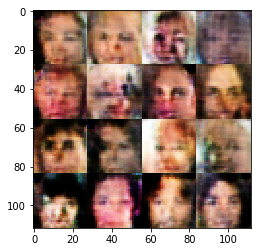

Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7911


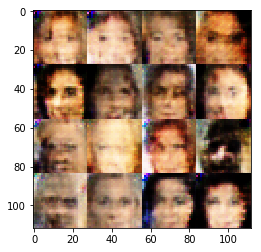

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 1.2567
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6746


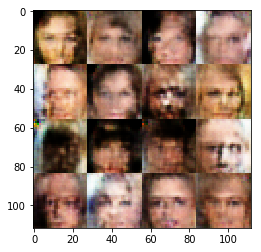

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6881


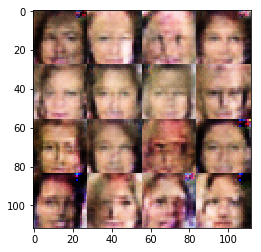

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 1.0925


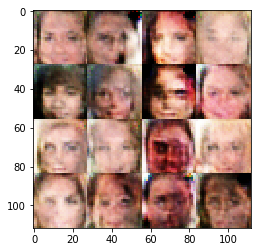

Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7123


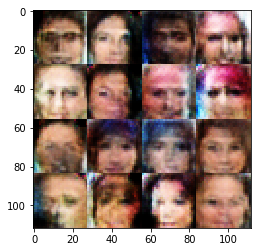

Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 1.0620
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8256


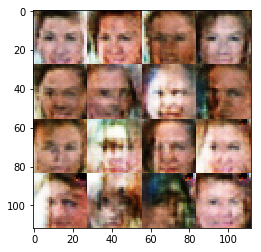

Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.0161


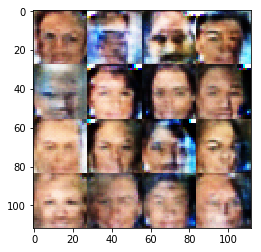

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7176


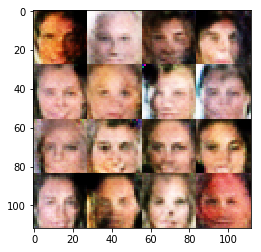

Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7645


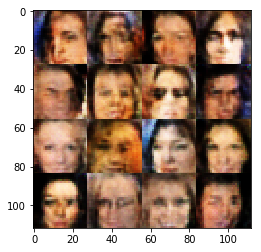

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8178


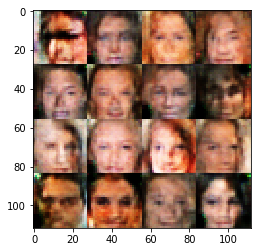

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.8544... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7346


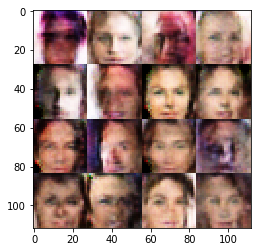

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7467


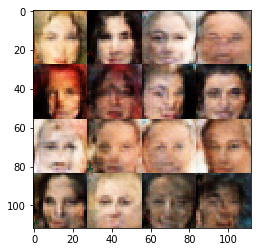

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.8764


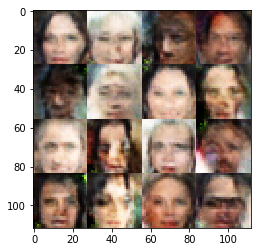

Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 1.1088


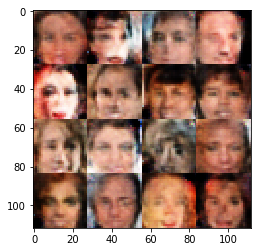

Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6684


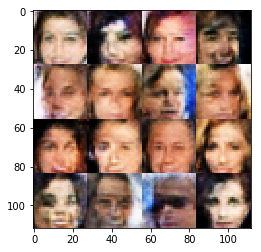

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7407


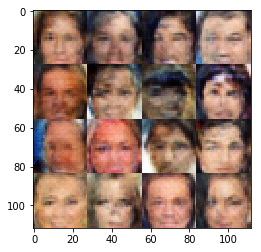

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7137


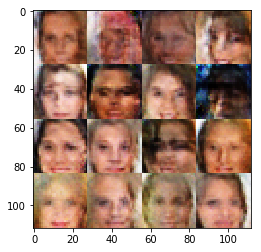

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7417


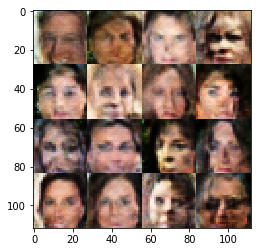

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8323


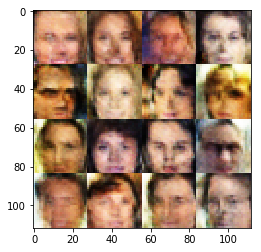

Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8148


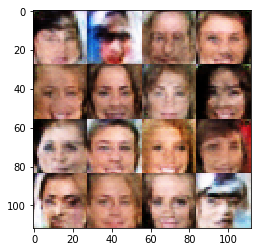

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7498


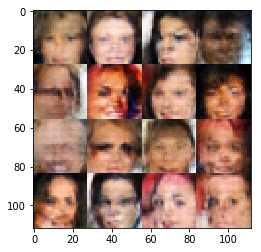

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6766


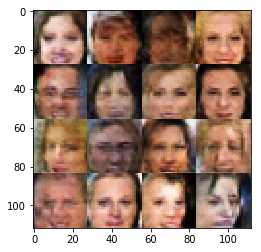

Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8348


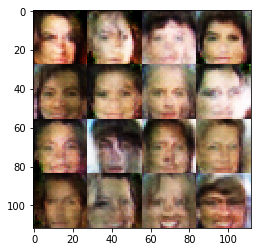

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7634


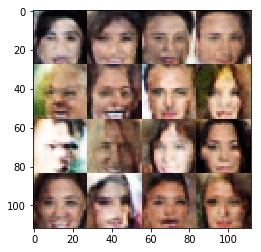

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7016


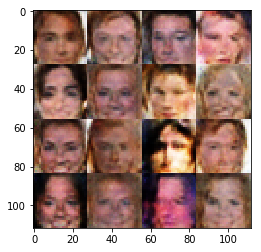

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8299


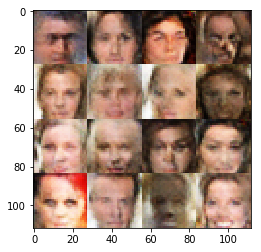

Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8243


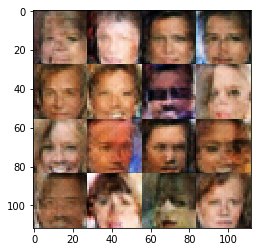

Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7551


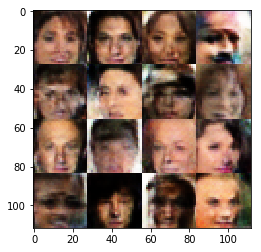

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8097


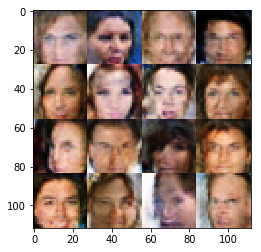

Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7149


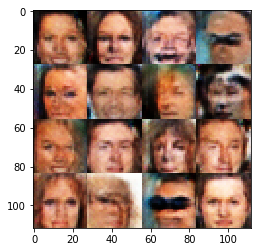

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7650


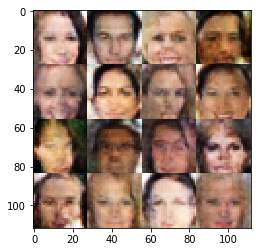

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7631


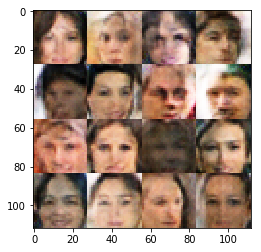

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7825


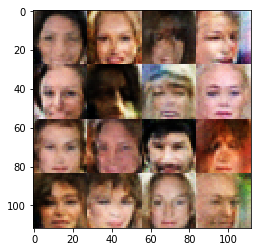

Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7512


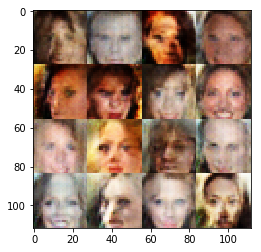

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7666


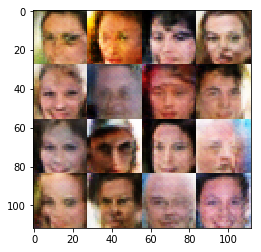

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7554


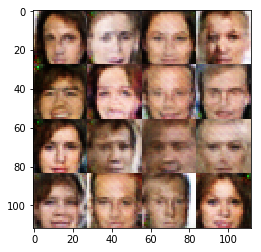

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7223


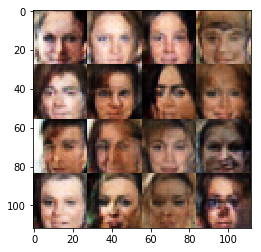

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8481


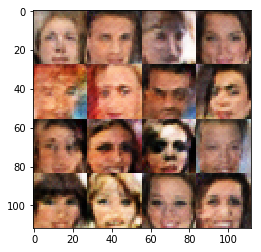

Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7233


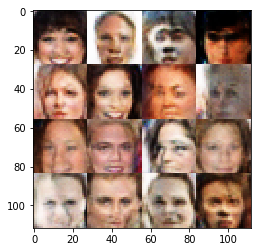

Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7742


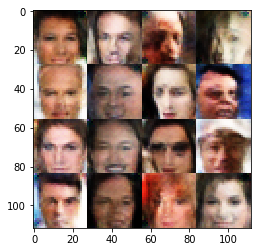

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7813


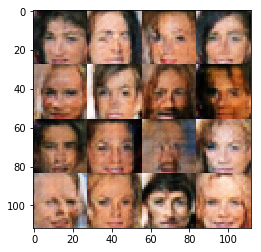

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 1.0242
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7843


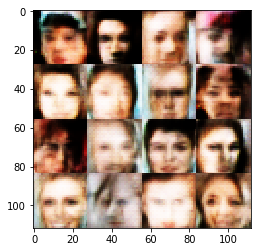

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8294


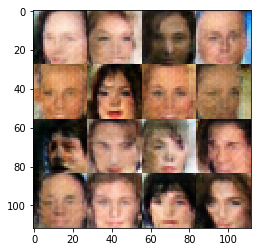

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7589


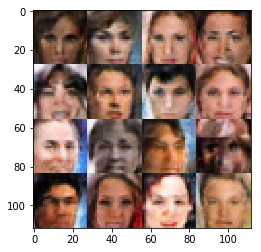

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7983


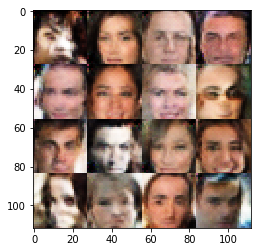

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7653


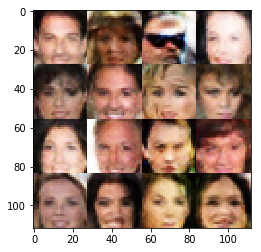

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6784


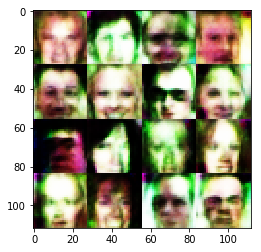

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7690


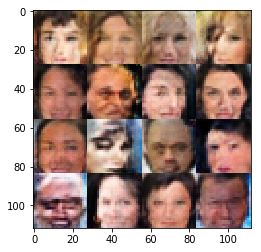

Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8064


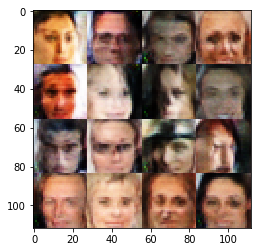

Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7766


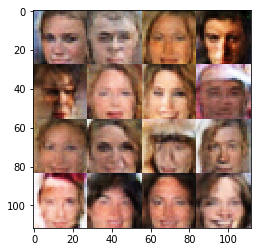

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7907


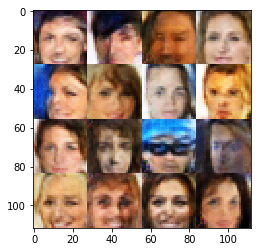

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7887


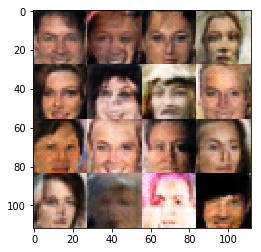

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7586


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.